In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from cv_master import Grid2DKernel, SatelliteImageData
from cv_master.cv import cv_classifer, nested_cv_classifer
from tqdm import tqdm

sns.set_style('whitegrid')

### Training & CVs

In [2]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, balanced_accuracy_score

from evalaute import eval_model_test_scheme1, eval_model_test_scheme2

In [3]:

COLUMNES = ['y', 'x', 'label', 'ndai', 'sd', 'corr', 'ra_df', 'ra_cf', 'ra_bf', 'ra_af', 'ra_an']
train_columns = ['ndai', 'sd', 'corr', 'ra_df', 'ra_cf', 'ra_bf', 'ra_af', 'ra_an']

imagem1 = pd.read_csv('cv_master/data/imagem1.txt',delim_whitespace=True, header=None)
imagem2 = pd.read_csv('cv_master/data/imagem2.txt',delim_whitespace=True, header=None)
imagem3 = pd.read_csv('cv_master/data/imagem3.txt',delim_whitespace=True, header=None)

imagem1.columns = COLUMNES
imagem2.columns = COLUMNES
imagem3.columns = COLUMNES

imagem1['Image_no'] = 1
imagem2['Image_no'] = 2
imagem3['Image_no'] = 3

image_set = pd.concat([imagem1, imagem2, imagem3], axis=0)
remap_labels = {
    1: 1, # Cloud
    -1: 0, # Not Cloud
    0: 2 # Unlabelled
}

image_set['label'] = image_set['label'].apply(lambda x: remap_labels[x])
image_set = image_set[image_set['label']!=2]

#### Test scheme 1 (CV + Fixed test set) ####
kernel = Grid2DKernel(55, 55)
image_test1 = SatelliteImageData(kernel, images=['imagem1.txt', 'imagem2.txt'])

# Load test set
COLUMNES = ['y', 'x', 'label', 'ndai', 'sd', 'corr', 'ra_df', 'ra_cf', 'ra_bf', 'ra_af', 'ra_an']
train_columns = ['ndai', 'sd', 'corr', 'ra_df', 'ra_cf', 'ra_bf', 'ra_af', 'ra_an']

X_train_1 = image_set[image_set['Image_no'].isin([2,3])][train_columns]
y_train_1 = image_set[image_set['Image_no'].isin([2,3])][['label']]

X_test_1 = image_set[image_set['Image_no'].isin([1])][train_columns]
y_test_1 = image_set[image_set['Image_no'].isin([1])][['label']]


#### Test scheme 2 (Nested CV + Testing)####
image_test2 = SatelliteImageData(kernel, images=['imagem1.txt', 'imagem2.txt', 'imagem3.txt'])

# metrics
metric_list = [accuracy_score, balanced_accuracy_score]

In [8]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from evalaute import eval_model_test_scheme1, eval_model_test_scheme2

np.random.seed(521)

model_dict = {'LR': LogisticRegression(penalty='l2', max_iter=1000),
              'RF': RandomForestClassifier(),
              'CART': DecisionTreeClassifier(min_samples_split=10),
              'Adaboost': AdaBoostClassifier(),
              'Baseline': DummyClassifier(strategy='constant', constant=0)}

result_store = {}
for mod_name, model in model_dict.items():
    scheme1_results = eval_model_test_scheme1(
        model,
        dataset1=(image_test1, (X_train_1, y_train_1), (X_test_1, y_test_1)),
        metric_list=metric_list
    )
    scheme2_results = eval_model_test_scheme2(model, dataset2=image_test2, metric_list=metric_list)
    result_store[mod_name] = [scheme1_results, scheme2_results]

/home/ztang484/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/ztang484/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/ztang484/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/ztang484/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/ztang484/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes n

In [9]:
model_namelist_for_plot = ['LR', 'RF', 'CART', 'Adaboost']
model_namelist = model_namelist_for_plot + ['Baseline']

scheme1_results = pd.DataFrame.from_dict({
    'Test Acc': [result_store[x][0]['Test_acc'] for x in model_namelist],
    'Test Balanced Acc': [result_store[x][0]['Test_bal_acc'] for x in model_namelist],
    'CV Acc': [result_store[x][0]['CV_acc'] for x in model_namelist],
    'CV Balanced ACC':[result_store[x][0]['CV_bal_acc'] for x in model_namelist],
})
scheme1_results.index = model_namelist
scheme1_results

,Test Acc,Test Balanced Acc,CV Acc,CV Balanced ACC
LR,0.927326,0.927293,0.880879,0.870181
RF,0.913595,0.914592,0.879776,0.878848
CART,0.856722,0.858214,0.872440,0.868227
Adaboost,0.934813,0.938213,0.884109,0.874890
Baseline,0.522009,0.522009,0.616990,0.523810


### CV Performances

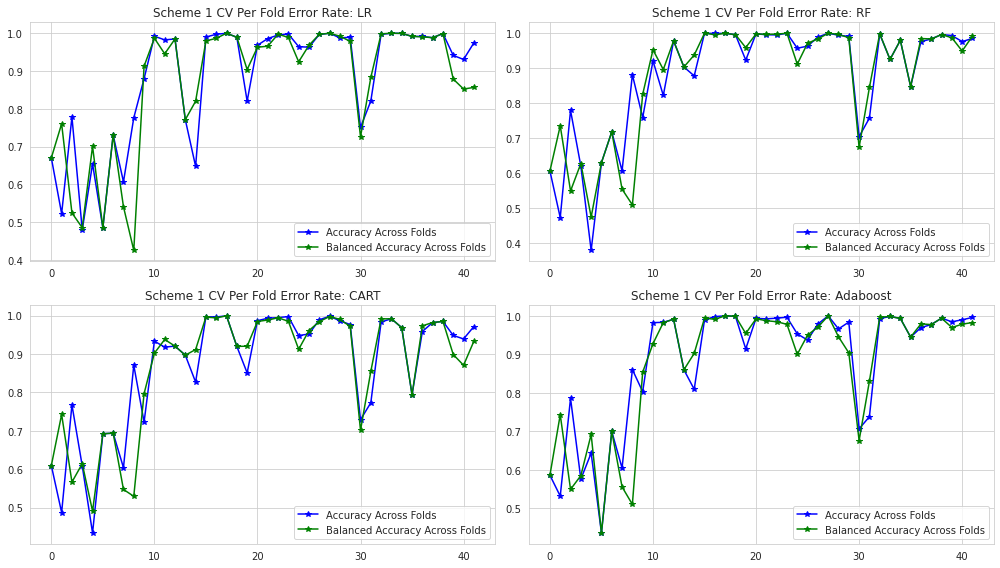

In [60]:
coords = [(0,0),(0,1),(1,0),(1,1)]
fig, ax = plt.subplots(2,2,figsize=(14, 8))

for co,mod in zip(coords,model_namelist_for_plot):
    
    fold_ids = list(range(len(result_store[mod][0]['scheme_1_raw'])))

    acc_scores = [result_store[mod][0]['scheme_1_raw'][f][0][0] for f in fold_ids]

    bal_acc_scores = [result_store[mod][0]['scheme_1_raw'][f][0][1] for f in fold_ids]

    ax[co[0],co[1]].plot(fold_ids, acc_scores, marker='*', color='blue', label='Accuracy Across Folds')
    ax[co[0],co[1]].plot(fold_ids, bal_acc_scores, marker='*',color='green', label='Balanced Accuracy Across Folds')
    ax[co[0],co[1]].legend()
    ax[co[0],co[1]].title.set_text(f'Scheme 1 CV Per Fold Error Rate: {mod}')

fig.tight_layout()
fig.show()
# plt.savefig('statics/test_Scheme_1_Fold_error.png')

In [55]:
scheme2_results = pd.DataFrame.from_dict({'Test Acc': [result_store[x][1]['Test_acc'] for x in model_namelist],
                       'Test Balanced Acc': [result_store[x][1]['Test_bal_acc'] for x in model_namelist],
                       'CV Acc': [result_store[x][1]['CV_acc'] for x in model_namelist],
                       'CV Balanced ACC':[result_store[x][1]['CV_bal_acc'] for x in model_namelist]})
scheme2_results.index = model_namelist
scheme2_results

,Test Acc,Test Balanced Acc,CV Acc,CV Balanced ACC
LR,0.876838,0.821027,0.876838,0.821027
RF,0.877752,0.845286,0.880207,0.847173
CART,0.860441,0.822074,0.860401,0.822271
Adaboost,0.867469,0.805109,0.867469,0.805109
Baseline,0.603075,0.537500,0.603075,0.537500


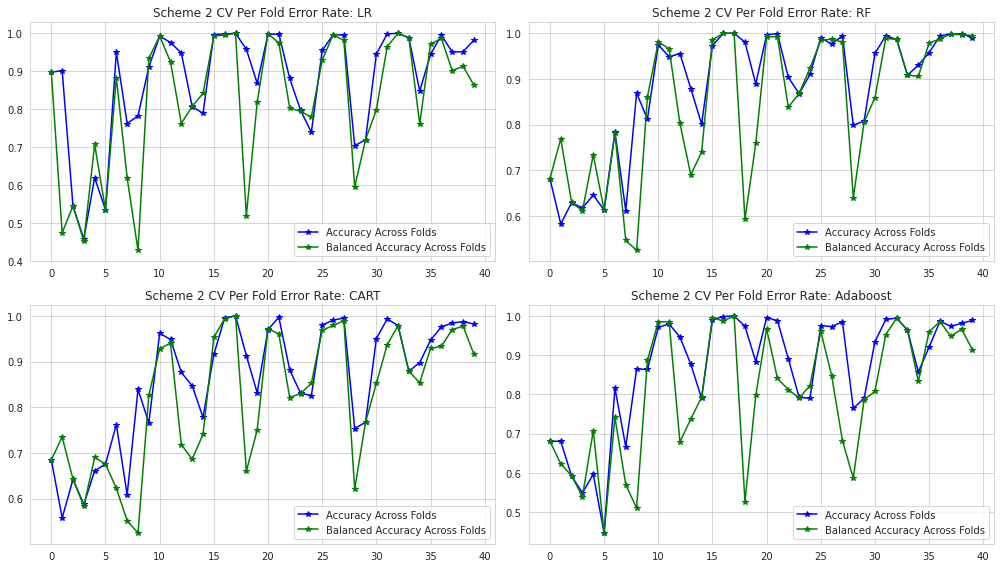

In [61]:
coords = [(0,0),(0,1),(1,0),(1,1)]
fig, ax = plt.subplots(2,2,figsize=(14, 8))

for co,mod in zip(coords,model_namelist_for_plot):
    
    fold_ids = list(range(len(result_store[mod][1]['scheme_2_raw'])))
    acc_scores = [result_store[mod][1]['scheme_2_raw'][f][0][0] for f in fold_ids]
    bal_acc_scores = [result_store[mod][1]['scheme_2_raw'][f][0][1] for f in fold_ids]

    ax[co[0],co[1]].plot(fold_ids, acc_scores, marker='*', color='blue', label='Accuracy Across Folds')
    ax[co[0],co[1]].plot(fold_ids, bal_acc_scores, marker='*',color='green', label='Balanced Accuracy Across Folds')
    ax[co[0],co[1]].legend()
    ax[co[0],co[1]].title.set_text(f'Scheme 2 CV Per Fold Error Rate: {mod}')

fig.tight_layout()
fig.show()
# plt.savefig('statics/test_Scheme2_fold_error.png')

### ROC Plots

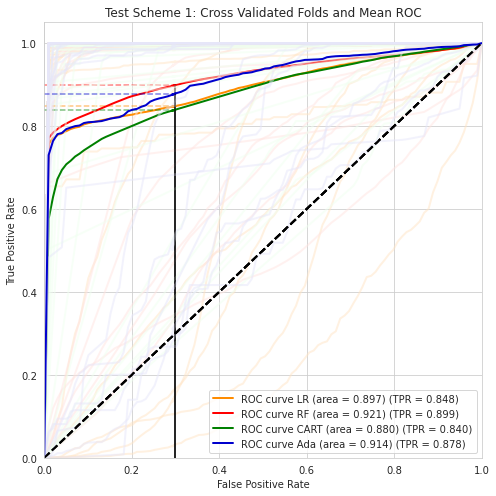

In [63]:
import warnings
from plot import plot_CV_ROC

warnings.filterwarnings("ignore")

chosen_fpr = 0.3

fig, ax = plt.subplots(figsize=(7,7))

plot_CV_ROC(result_store['LR'][0]['scheme_1_raw'],
            'bisque',
            'darkorange',
            'LR',
            ax=ax,
            chosen_fpr=chosen_fpr)

plot_CV_ROC(result_store['RF'][0]['scheme_1_raw'],
            'mistyrose',
            'red',
            'RF',
            ax=ax,
            chosen_fpr=chosen_fpr)


plot_CV_ROC(result_store['CART'][0]['scheme_1_raw'],
            'honeydew',
            'green',
            'CART',
            ax=ax,
            chosen_fpr=chosen_fpr)


plot_CV_ROC(result_store['Adaboost'][0]['scheme_1_raw'],
            'lavender',
            'mediumblue',
            'Ada',
            ax=ax,
            chosen_fpr=chosen_fpr)

ax.legend()
ax.title.set_text('Test Scheme 1: Cross Validated Folds and Mean ROC')

fig.tight_layout()
fig.show()
# plt.savefig('statics/test_Scheme1_cv_roc.png')

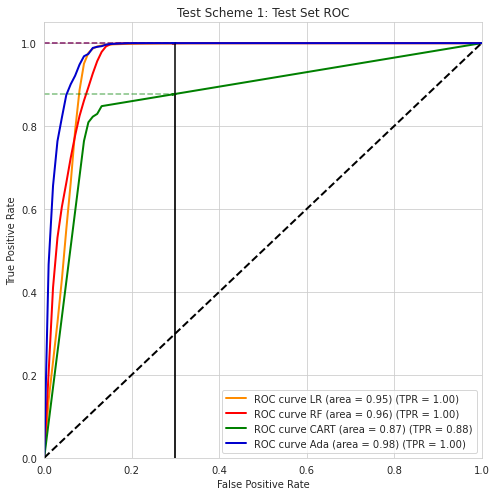

In [64]:
from sklearn.metrics import roc_curve, auc
from plot import find_change_point

test_scores = [result_store[mod_name][0]['test_scores'] for mod_name in model_namelist]

fpr_tpr_col = []
roc_col = []

for ts in test_scores:

    fpr, tpr, _ = roc_curve(y_test_1.values,ts[:,1])
    roc_auc = auc(fpr, tpr)
    
    fpr_tpr_col.append((fpr, tpr))
    roc_col.append(roc_auc)
    
model_names = ['LR', 'RF','CART', 'Ada']
model_colors = ['darkorange','red','green','mediumblue']


fig, ax = plt.subplots(figsize=(7,7))

lw = 2

mean_fpr = np.linspace(0, 1, 100)
# Add in the chosen FPR level
mean_fpr = np.insert(mean_fpr, find_change_point(mean_fpr < chosen_fpr), chosen_fpr)

for fpr_tpr, roc, mod_name, mod_col in zip(fpr_tpr_col,
                                           roc_col,
                                           model_names,
                                           model_colors):
    
    interp_tpr = np.interp(mean_fpr, fpr_tpr[0], fpr_tpr[1])
    # Find associated mean tpr value
    tpr_index = np.where(mean_fpr == chosen_fpr)[0][0]
    tpr_val_chosen = interp_tpr[tpr_index]
    
    ax.plot(
        mean_fpr,
        interp_tpr,
        color=mod_col,
        lw=lw,
        label="ROC curve %s (area = %0.2f) (TPR = %0.2f)" % (mod_name,roc,tpr_val_chosen),
    )
    
    # Plot tpr val
    ax.plot([chosen_fpr,chosen_fpr],
            [0,tpr_val_chosen], alpha=0.5, color='black', ls='-')

    ax.plot([0,chosen_fpr],
            [tpr_val_chosen,tpr_val_chosen], alpha=0.5, color=mod_col, ls='--')
    
    
ax.plot([0, 1], [0, 1], color="black", lw=lw, linestyle="--")
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.title.set_text("Test Scheme 1: Test Set ROC")
ax.legend(loc="lower right")

fig.tight_layout()
fig.show()

# plt.savefig('statics/test_Scheme1_test_roc.png')

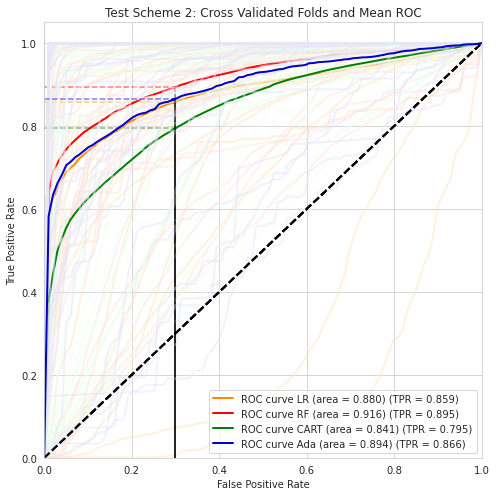

In [65]:
fig, ax = plt.subplots(figsize=(7,7))

plot_CV_ROC(result_store['LR'][1]['scheme_2_raw'],
            'bisque',
            'darkorange',
            'LR',
            ax=ax,
            chosen_fpr=chosen_fpr,
            nested_test=False)

plot_CV_ROC(result_store['RF'][1]['scheme_2_raw'],
            'mistyrose',
            'red',
            'RF',
            ax=ax,
            chosen_fpr=chosen_fpr,
            nested_test=False)


plot_CV_ROC(result_store['CART'][1]['scheme_2_raw'],
            'honeydew',
            'green',
            'CART',
            ax=ax,
            chosen_fpr=chosen_fpr,
            nested_test=False)


plot_CV_ROC(result_store['Adaboost'][1]['scheme_2_raw'],
            'lavender',
            'mediumblue',
            'Ada',
            ax=ax,
            chosen_fpr=chosen_fpr,
            nested_test=False)

ax.legend()
ax.title.set_text('Test Scheme 2: Cross Validated Folds and Mean ROC')

fig.tight_layout()
fig.show()

# plt.savefig('statics/test_Scheme2_cv_roc.png')

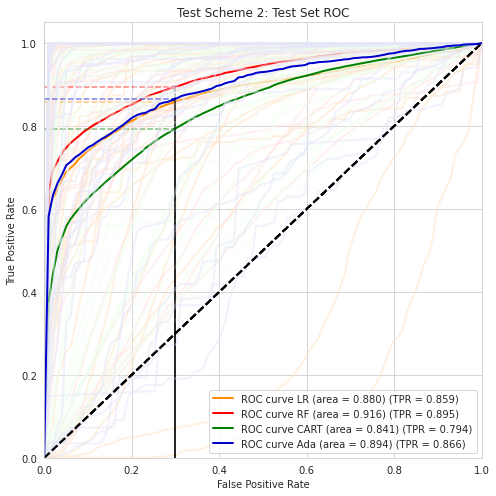

In [66]:
fig,ax = plt.subplots(figsize=(7,7))

plot_CV_ROC(result_store['LR'][1]['scheme_2_raw'],
            'bisque',
            'darkorange',
            'LR',
            ax=ax,
            chosen_fpr=chosen_fpr,
            nested_test=True)

plot_CV_ROC(result_store['RF'][1]['scheme_2_raw'],
            'mistyrose',
            'red',
            'RF',
            ax=ax,
            chosen_fpr=chosen_fpr,
            nested_test=True)


plot_CV_ROC(result_store['CART'][1]['scheme_2_raw'],
            'honeydew',
            'green',
            'CART',
            ax=ax,
            chosen_fpr=chosen_fpr,
            nested_test=True)


plot_CV_ROC(result_store['Adaboost'][1]['scheme_2_raw'],
            'lavender',
            'mediumblue',
            'Ada',
            ax=ax,
            chosen_fpr=chosen_fpr,
            nested_test=True)

ax.legend()
ax.title.set_text('Test Scheme 2: Test Set ROC')

fig.tight_layout()
fig.show()

# plt.savefig('statics/test_Scheme2_test_roc.png')

### Diagnostics

In [20]:
dt_stump = DecisionTreeClassifier(max_depth=1, min_samples_leaf=1)
dt_stump.fit(X_train_1[train_columns], y_train_1)

stump_pred = dt_stump.predict(X_test_1[train_columns])
print(np.mean(stump_pred == y_test_1.values.reshape(-1)))
print(balanced_accuracy_score(stump_pred, y_test_1.values.reshape(-1)))


0.9349953742026587
0.9380875956349927


In [47]:
adaboost_analysis = AdaBoostClassifier(n_estimators=50,learning_rate=0.1)
adaboost_analysis.fit(X_train_1[train_columns], y_train_1)

ada_pred = adaboost_analysis.predict(X_test_1[train_columns])
print(np.mean(ada_pred == y_test_1.values.reshape(-1)))
print(balanced_accuracy_score(ada_pred, y_test_1.values.reshape(-1)))

/home/ztang484/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.6036522388189243
0.5469871382024046


In [22]:
log_reg_analysis = LogisticRegression(penalty='l2', max_iter=1000)
log_reg_analysis.fit(X_train_1[train_columns], y_train_1)

lr_pred = log_reg_analysis.predict(X_test_1[train_columns])
print(np.mean(lr_pred == y_test_1.values.reshape(-1)))
print(balanced_accuracy_score(lr_pred, y_test_1.values.reshape(-1)))

/home/ztang484/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9273262891366801
0.9272930328449207


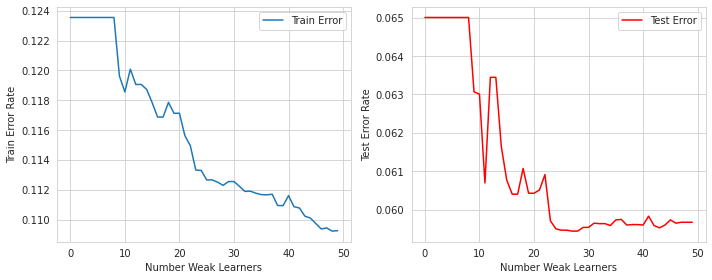

In [67]:
n_est = adaboost_analysis.n_estimators

ada_train_err = np.zeros((n_est,))
for i, y_pred_train in enumerate(adaboost_analysis.staged_predict(X_train_1[train_columns])):
    ada_train_err[i] = 1 - accuracy_score(y_pred_train, y_train_1.values)

ada_test_err = np.zeros((n_est,))
for i, y_pred_test in enumerate(adaboost_analysis.staged_predict(X_test_1[train_columns])):
    ada_test_err[i] = 1 - accuracy_score(y_pred_test, y_test_1.values)

fig, ax = plt.subplots(1,2, figsize=(10,4))

ax[0].plot(range(n_est),ada_train_err,label='Train Error')
ax[1].plot(range(n_est),ada_test_err,color='red', label='Test Error')
ax[0].legend()
ax[1].legend()
ax[0].set_xlabel('Number Weak Learners')
ax[1].set_xlabel('Number Weak Learners')

ax[0].set_ylabel('Train Error Rate')
ax[1].set_ylabel('Test Error Rate')

fig.tight_layout()
fig.show()
# plt.savefig('statics/ada_iterations.png')

### Prediction vs True Comparison

In [4]:
from plot import plot_heatmap, get_heatmap_data

In [5]:
X_train_1 = image_set[image_set['Image_no'].isin([1, 2])][train_columns]
y_train_1 = image_set[image_set['Image_no'].isin([1, 2])][['label']]

X_test_1 = image_set[image_set['Image_no'].isin([3])][train_columns]
y_test_1 = image_set[image_set['Image_no'].isin([3])][['label']]

adaboost_analysis = AdaBoostClassifier(n_estimators=50, learning_rate=0.1)
adaboost_analysis.fit(X_train_1[train_columns], y_train_1)

log_reg_analysis = LogisticRegression(penalty='l2', max_iter=1000)
log_reg_analysis.fit(X_train_1[train_columns], y_train_1)

/home/ztang484/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ztang484/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(max_iter=1000)

In [7]:
COLUMNES = ['y', 'x', 'label', 'ndai', 'sd', 'corr', 'ra_df', 'ra_cf', 'ra_bf', 'ra_af', 'ra_an']
train_columns = ['ndai', 'sd', 'corr', 'ra_df', 'ra_cf', 'ra_bf', 'ra_af', 'ra_an']

imagem1 = pd.read_csv('cv_master/data/imagem1.txt',delim_whitespace=True, header=None)
imagem2 = pd.read_csv('cv_master/data/imagem2.txt',delim_whitespace=True, header=None)
imagem3 = pd.read_csv('cv_master/data/imagem3.txt',delim_whitespace=True, header=None)

imagem1.columns = COLUMNES
imagem2.columns = COLUMNES
imagem3.columns = COLUMNES

imagem1['Image_no'] = 1
imagem2['Image_no'] = 2
imagem3['Image_no'] = 3

image_set = pd.concat([imagem1, imagem2, imagem3],0)
remap_labels = {1: 1, -1: 0, 0: 2}
image_set['label_remaped'] = image_set['label'].apply(lambda x: remap_labels[x])

train_im = image_set[image_set['Image_no']!=3]
train_im_features = train_im[train_columns]
prob_preds = adaboost_analysis.predict_proba(train_im_features)[:,1]
train_im['Predicted_Probs'] = prob_preds

test_im = image_set[image_set['Image_no']==3]
test_im_features = test_im[train_columns]
prob_preds = adaboost_analysis.predict_proba(test_im_features)[:,1]
test_im['Predicted_Probs'] = prob_preds

/tmp/ipykernel_385/4241036326.py:16: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  image_set = pd.concat([imagem1, imagem2, imagem3],0)
/tmp/ipykernel_385/4241036326.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_im['Predicted_Probs'] = prob_preds
/tmp/ipykernel_385/4241036326.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_im['Predicted_Probs'] = prob_preds


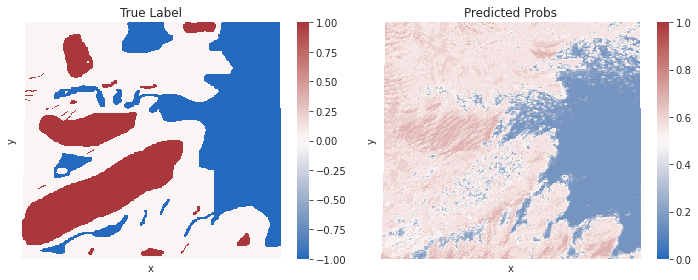

In [10]:
image = test_im.copy()

fig, ax = plt.subplots(1, 2,figsize=(5*2, 4))

# universial divergent color map
cmap = sns.color_palette("vlag", as_cmap=True)
plot_heatmap(get_heatmap_data(image, 'label'), label='True Label', cmap=cmap, ax=ax[0], vmin=-1, vmax=1)
plot_heatmap(get_heatmap_data(image, 'Predicted_Probs'), label='Predicted Probs', cmap=cmap, ax=ax[1], vmin=0, vmax=1)

fig.tight_layout()
fig.show()
# plt.savefig('statics/ada_test_prob.png')

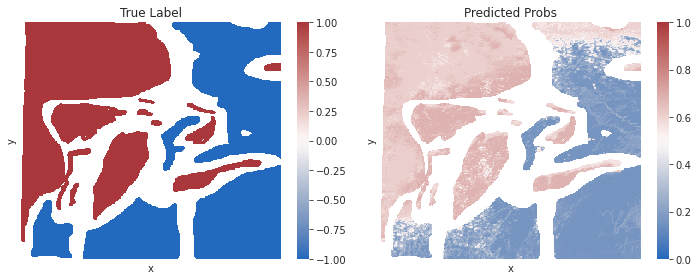

In [11]:
image = train_im[train_im['Image_no']==1].copy()

fig, ax = plt.subplots(1,2,figsize=(5*2, 4))

# universial divergent color map
cmap = sns.color_palette("vlag", as_cmap=True)
plot_heatmap(get_heatmap_data(image, 'label'), label='True Label', cmap=cmap, ax=ax[0], vmin=-1, vmax=1)
plot_heatmap(get_heatmap_data(image, 'Predicted_Probs'), label='Predicted Probs', cmap=cmap, ax=ax[1], vmin=0, vmax=1)

fig.tight_layout()
fig.show()
# plt.savefig('statics/ada_train_prob1.png')

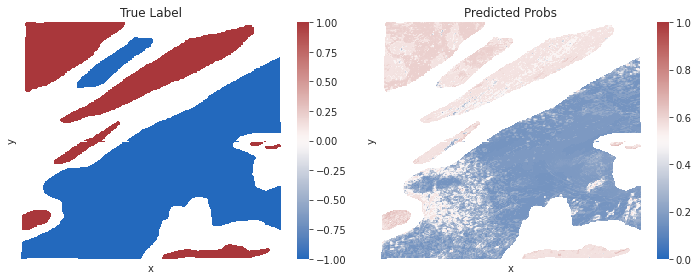

In [12]:
image = train_im[train_im['Image_no']==2].copy()

fig, ax = plt.subplots(1,2,figsize=(5*2, 4))

# universial divergent color map
cmap = sns.color_palette("vlag", as_cmap=True)
plot_heatmap(get_heatmap_data(image, 'label'), label='True Label', cmap=cmap, ax=ax[0], vmin=-1, vmax=1)
plot_heatmap(get_heatmap_data(image, 'Predicted_Probs'), label='Predicted Probs', cmap=cmap, ax=ax[1], vmin=0, vmax=1)

fig.tight_layout()
fig.show()
# plt.savefig('statics/ada_train_prob2.png')

### Feature Importances

/tmp/ipykernel_11272/517728319.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([""]+train_columns)


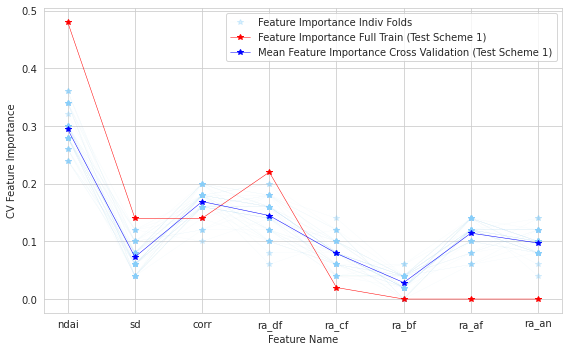

In [19]:
test_feaure_importance = pd.DataFrame([adaboost_analysis.feature_names_in_,
            adaboost_analysis.feature_importances_]).T

test_feaure_importance.columns = ['Feature Name','Importance']

cv_importances = [clf_k[-1].feature_importances_ for clf_k in result_store['Adaboost'][0]['scheme_1_raw']]

cv_impt = [pd.DataFrame([adaboost_analysis.feature_names_in_,
            impt]).T for impt in cv_importances]

mean_cv_importance = (1/len(cv_importances)) * sum(cv_importances)


fig, ax = plt.subplots(figsize=(8, 5))
x_vals = list(range(1, 1+len(train_columns)))

for impt in cv_importances:
    ax.plot(x_vals, impt, color='lightskyblue', lw=0.1, alpha=0.3,marker='*')

ax.plot(
    x_vals, impt, color='lightskyblue',
    lw=0.1, alpha=0.3,marker='*',label='Feature Importance Indiv Folds'
)
ax.plot(
    x_vals, test_feaure_importance['Importance'], color='red',
    lw=0.5,alpha=1,marker='*', label='Feature Importance Full Train (Test Scheme 1)'
)
ax.plot(
    x_vals, mean_cv_importance, color='blue', lw=0.5,
    alpha=1,marker='*', label='Mean Feature Importance Cross Validation (Test Scheme 1)'
)
    
ax.set_xticklabels([""]+train_columns)
ax.set_xlabel("Feature Name")
ax.set_ylabel("CV Feature Importance")
ax.legend()

fig.tight_layout()
fig.show()

### Misclassfied Analysis

In [39]:
X_test_1_analysis = test_im.copy()
ada_pred = adaboost_analysis.predict(X_test_1_analysis[train_columns])
X_test_1_analysis['y_true'] = y_test_1.values.reshape(-1)
X_test_1_analysis['y_pred'] = ada_pred

X_test_1_analysis['Misclassified'] = X_test_1_analysis['y_pred'] != X_test_1_analysis['y_true'] 

true_neg = X_test_1_analysis[X_test_1_analysis['y_true']==0]
true_pos = X_test_1_analysis[X_test_1_analysis['y_true']==1]

print(true_neg['Misclassified'].value_counts())
print(true_pos['Misclassified'].value_counts())

subsampled_true_neg = pd.concat([true_neg[true_neg['Misclassified']==False].sample(10000),
                      true_neg[true_neg['Misclassified']==True]])

subsampled_true_pos = pd.concat([true_pos[true_pos['Misclassified']==False].sample(2000),
                      true_pos[true_pos['Misclassified']==True]])

subsampled_true_neg['Misclassified'].value_counts()
subsampled_true_pos['Misclassified'].value_counts()

True     46754
False    13467
Name: Misclassified, dtype: int64
False    17425
True      3819
Name: Misclassified, dtype: int64


True     3819
False    2000
Name: Misclassified, dtype: int64

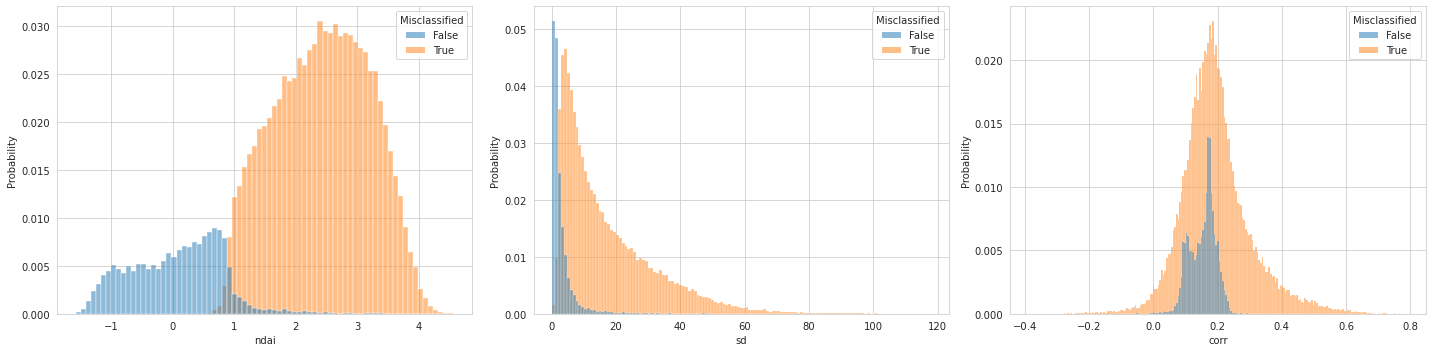

In [40]:
fig,ax = plt.subplots(1,3,figsize=(20,5))

sns.histplot(subsampled_true_neg, x="ndai", hue="Misclassified", ax=ax[0],stat='probability')
sns.histplot(subsampled_true_neg, x="sd", hue="Misclassified", ax=ax[1],stat='probability')
sns.histplot(subsampled_true_neg, x="corr", hue="Misclassified", ax=ax[2],stat='probability')

plt.tight_layout()

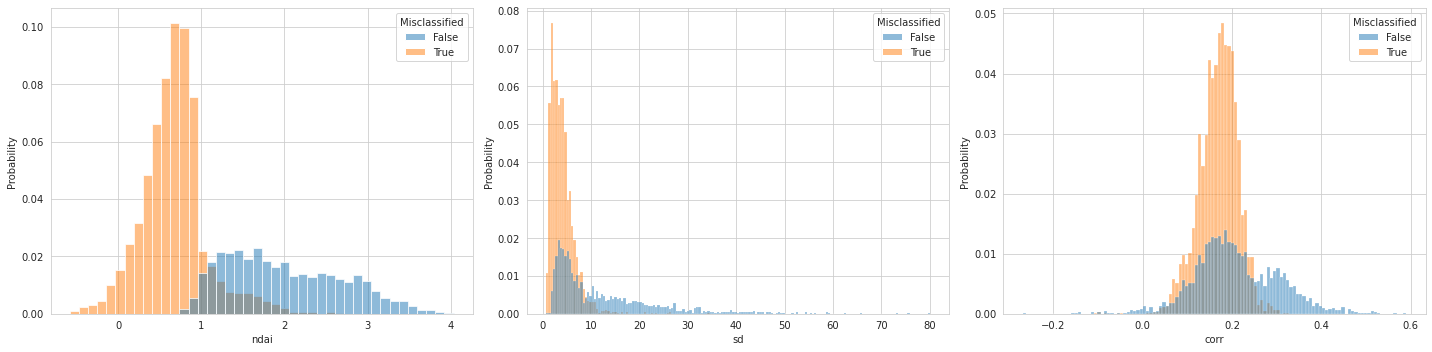

In [41]:
fig,ax = plt.subplots(1,3,figsize=(20, 5))

sns.histplot(subsampled_true_pos, x="ndai", hue="Misclassified", ax=ax[0],stat='probability')
sns.histplot(subsampled_true_pos, x="sd", hue="Misclassified", ax=ax[1],stat='probability')
sns.histplot(subsampled_true_pos, x="corr", hue="Misclassified", ax=ax[2],stat='probability')

plt.tight_layout()

### Decison Boundaries

In [13]:
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE

train_im = train_im[train_im['label_remaped']!=2]

pos_samps = train_im[train_im['label_remaped']==1].copy().sample(2500)
neg_samps = train_im[train_im['label_remaped']==0].copy().sample(3000)

projected_points = pd.concat([pos_samps, neg_samps])

pca_samples = train_im.sample(4000)
pca = PCA(n_components=2)
pca = KernelPCA(n_components=2,
                kernel='linear',degree=2,
                gamma=0.00000001,
                fit_inverse_transform=True,
                alpha=0.1)
#tsne = TSNE(n_components=2)
# Standardize
pca.fit(pca_samples[train_columns])
out = pca.transform(projected_points[train_columns])

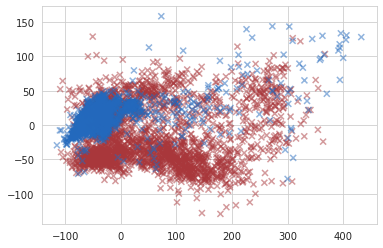

In [14]:
plt.scatter(out[:,0],
            out[:,1],
            color=cmap(projected_points['label']),
            alpha=0.5,
           marker='x')

/home/ztang484/miniconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/tmp/ipykernel_385/127235748.py:47: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(cm.ScalarMappable(norm=None, cmap=cmap), ax=ax)


'\nfrom mpl_toolkits.axes_grid1 import make_axes_locatable\n\ndivider = make_axes_locatable(ax)\ncax = divider.append_axes("right", size="5%", pad=0.05)\n\nplt.colorbar(im_plot, cax=cax)\n\nplt.show()\n'

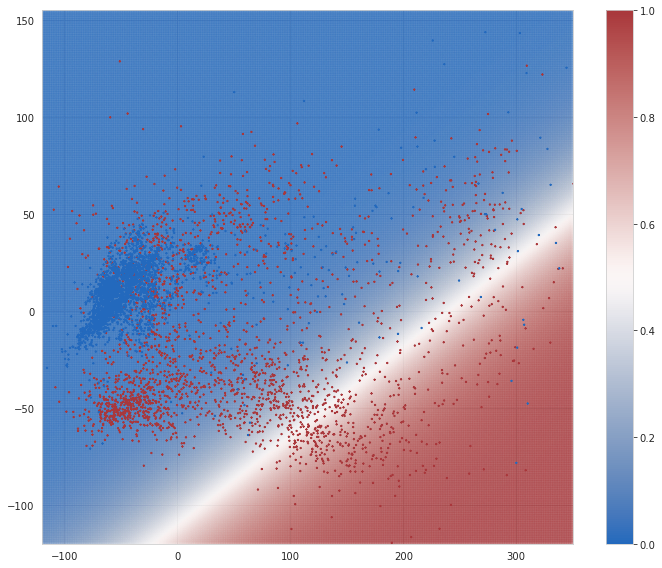

In [15]:
x_min = -120
x_max = 350
y_min = -120
y_max = 155

x_range = np.linspace(x_min, x_max, 300)
y_range = np.linspace(y_min, y_max,300)
low_dim_cands = np.array([[x0, y0] for x0 in x_range for y0 in y_range])

high_dim_rep = pca.inverse_transform(low_dim_cands)

# Pass high dim rep into classifier
low_dim_cands_labels = log_reg_analysis.predict_proba(high_dim_rep)
#low_dim_cands_labels = adaboost_analysis.predict_proba(high_dim_rep)

fig, ax = plt.subplots(figsize=(10,8))


cmap_labels = {0: 'powderblue',
               1: 'mistyrose'}

#low_dim_cands_colors =  pd.Series(low_dim_cands_labels).apply(lambda x: cmap_labels[x])

"""
ax.scatter(low_dim_cands[:,0],
            low_dim_cands[:,1],
            color=low_dim_cands_colors,
            alpha=0.1)
"""
im_plot = ax.scatter(low_dim_cands[:,0],
            low_dim_cands[:,1],
            color=cmap(low_dim_cands_labels[:,1]),
            alpha=0.1)


ax.scatter(out[:,0],
            out[:,1],
            color=cmap(projected_points['label']),
            alpha=1,
           marker='x',s=2)

ax.set_ylim([y_min, y_max])
ax.set_xlim([x_min, x_max])

from matplotlib import cm, colors

fig.colorbar(cm.ScalarMappable(norm=None, cmap=cmap), ax=ax)
fig.tight_layout()
fig.show()
# plt.savefig('statics/log_reg_decision_surface.png')

"""
from mpl_toolkits.axes_grid1 import make_axes_locatable

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im_plot, cax=cax)

plt.show()
"""

/home/ztang484/miniconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/tmp/ipykernel_385/1550526641.py:47: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(cm.ScalarMappable(norm=None, cmap=cmap), ax=ax)


'\nfrom mpl_toolkits.axes_grid1 import make_axes_locatable\n\ndivider = make_axes_locatable(ax)\ncax = divider.append_axes("right", size="5%", pad=0.05)\n\nplt.colorbar(im_plot, cax=cax)\n\nplt.show()\n'

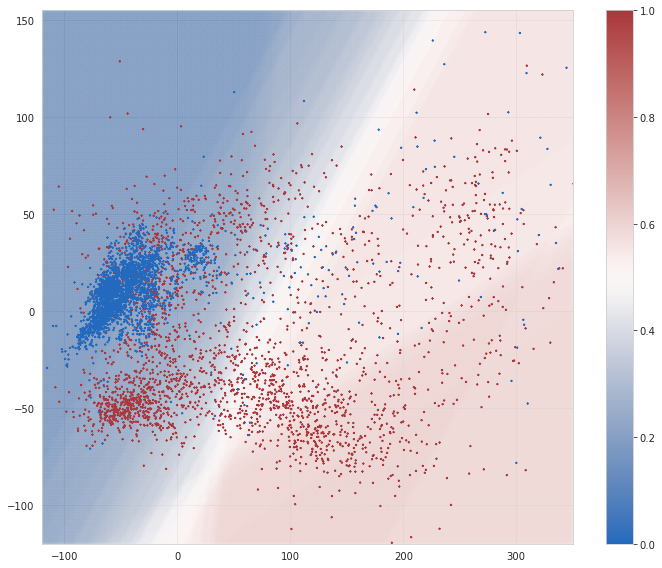

In [17]:
x_min = -120
x_max = 350
y_min = -120
y_max = 155

x_range = np.linspace(x_min, x_max, 300)
y_range = np.linspace(y_min, y_max,300)
low_dim_cands = np.array([[x0, y0] for x0 in x_range for y0 in y_range])

high_dim_rep = pca.inverse_transform(low_dim_cands)

# Pass high dim rep into classifier
#low_dim_cands_labels = log_reg_analysis.predict_proba(high_dim_rep)
low_dim_cands_labels = adaboost_analysis.predict_proba(high_dim_rep)

fig, ax =plt.subplots(figsize=(10,8))


cmap_labels = {0: 'powderblue',
               1: 'mistyrose'}

#low_dim_cands_colors =  pd.Series(low_dim_cands_labels).apply(lambda x: cmap_labels[x])

"""
ax.scatter(low_dim_cands[:,0],
            low_dim_cands[:,1],
            color=low_dim_cands_colors,
            alpha=0.1)
"""
im_plot = ax.scatter(low_dim_cands[:,0],
            low_dim_cands[:,1],
            color=cmap(low_dim_cands_labels[:,1]),
            alpha=0.1)


ax.scatter(out[:,0],
            out[:,1],
            color=cmap(projected_points['label']),
            alpha=1,
           marker='x',s=2)

ax.set_ylim([y_min, y_max])
ax.set_xlim([x_min, x_max])

from matplotlib import cm, colors

fig.colorbar(cm.ScalarMappable(norm=None, cmap=cmap), ax=ax)
fig.tight_layout()
fig.show()

# plt.savefig('statics/PCA_decision_surface.png')

"""
from mpl_toolkits.axes_grid1 import make_axes_locatable

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im_plot, cax=cax)

plt.show()
"""